## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error

from pysim import SimRegressor

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

**Usage**

```python
from pysim import SimRegressor
clf = SimRegressor(method="first_order", reg_lambda=0.1, reg_gamma=10, knot_num=20, knot_dist="uniform", spline="smoothing_spline", degree=2, random_state=0)
## clf.fit(x, y)
```

**Hyperparameters**

- method: the base method for estimating the projection coefficients in sparse SIM. default="first_order"

        "first_order": First-order Stein's Identity via sparse PCA solver

        "second_order": Second-order Stein's Identity via sparse PCA solver

        "first_order_thres": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- spline: The type of spline for fitting the curve. default="smoothing_spline"
        
        "smoothing_spline": Smoothing spline

        "p_spline": P-spline

        "mono_p_spline": P-spline with monotonic constraint
        
        "a_spline": Adaptive B-spline

- reg_gamma: The regularization strength of the spline algorithm. default=0.1.

        For spline="smoothing_spline", it ranges from 0 to 1 
        
        For spline="p_spline","mono_p_spline" or "a_spline", it ranges from 0 to $+\infty$.

- degree: The order of the spline basis, , not used in "smoothing_spline". default=2

- knot_num: The number of knots, not used in "smoothing_spline". default=20

- knot_dist: The method of specifying the knots, only used in "a_spline". default="uniform"

        "uniform": uniformly over the domain
        
        "quantile": uniform quantiles of the given input data (not available when spline="p_spline" or "mono_p_spline")

- random_state: the random seed. default=0

# Case 1: Sine Ridge Function

In [2]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)

In [11]:
clf = SimRegressor(spline="smoothing_spline", random_state=0)

The best hyperparameter combination can be selected via cross-validation

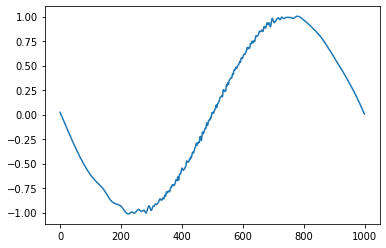

In [13]:
clf._validate_input()

In [3]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "reg_gamma": [0.2, 0.4, 0.6, 0.8, 1.0]}
grid = GridSearchCV(SimRegressor(spline="smoothing_spline", random_state=0), iid=False,
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  99 out of 150 | elapsed:    7.1s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.3s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Exception: Data must be 1-dimensional

In [4]:
grid.best_params_

{'method': 'first_order', 'reg_gamma': 0.2, 'reg_lambda': 0.1}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [5]:
clf = grid.best_estimator_
clf

SimRegressor(degree=2, knot_dist='uniform', knot_num=20, method='first_order',
             random_state=0, reg_gamma=0.2, reg_lambda=0.1,
             spline='smoothing_spline')

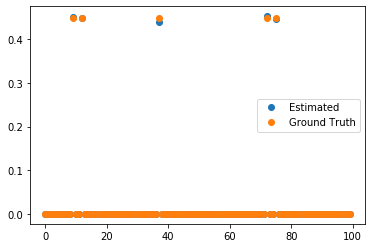

In [6]:
plt.plot(np.abs(clf.beta_), "o")
plt.plot(np.abs(beta), "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

In [7]:
clf.visualize()

NotFittedError: This SMSplineRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<Figure size 864x288 with 0 Axes>

## Case 2: Quadratic Ridge Function

In [ ]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)

In [ ]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "reg_gamma": [0.2, 0.4, 0.6, 0.8, 1.0]}
grid = GridSearchCV(SimRegressor(spline="smoothing_spline", random_state=0), iid=False,
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

In [ ]:
grid.best_params_

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [ ]:
clf = grid.best_estimator_
clf

In [ ]:
plt.plot(np.abs(clf.beta_), "o")
plt.plot(np.abs(beta), "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

In [ ]:
clf.visualize()

## Case 3: Improve a rough estimator via inner update

In [ ]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)

In [ ]:
%%time

clf = SimRegressor(degree=2, knot_num=20, reg_lambda=0.1, reg_gamma=0.4, spline="a_spline", random_state=0)
clf.fit(x, y)

In [ ]:
clf.visualize()

**Remark**：The data does not follow a normal distribution, so the performance is relatively poorer, we use adam optimizer to improve the estimation.

In [ ]:
clf.fit_inner_update(x, y, verbose=True, n_inner_iter_no_change=1)

**Remark**: fit_inner_update is not available for spline="p_spline" or "mono_p_spline"

In [ ]:
clf.visualize()